In [1]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/int/'

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()

tjy_udf:  ['H_find', 'Kap_D', 'git_sync', 'lighten_color', 'plot_anim', 'plot_pha', 'ticks']


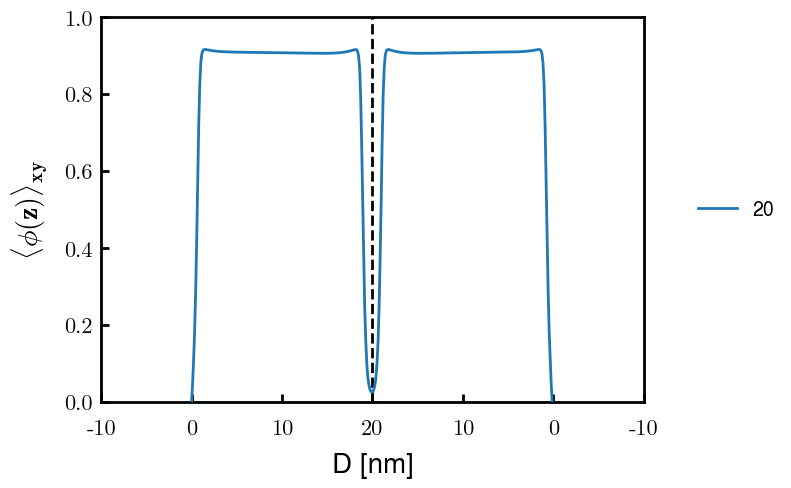

In [54]:
# SYSG Explore
labs = [20]
read_list = [GIT+'ph_s3020d{:05.0f}.dat'.format(i*1000) for i in labs]
max_d = max(labs) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 10 
plt.xlim(-step, step)
xrange = np.arange(-1*step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-1*step, max_d+0.1, step), np.arange(max_d-step, -1*(step+0.1), -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.xlabel('D [nm]')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

In [2]:
def CalcF(nx, y, dx=17/150):
    d = [(i*dx)/2 for i in nx]
    d1, y1 = [i for ind, i in enumerate(d) if not ind % 2], [i for ind, i in enumerate(y) if not ind % 2]
    d2, y2 = [i for ind, i in enumerate(d) if ind % 2]    , [i for ind, i in enumerate(y) if ind % 2]
    xf, yf = np.average([d1, d2], axis=0), [(y2[i]-y1[i])/(d1[i]-d2[i]) for i in range(round(len(d)/2))] # Force from squeezing (-dx)
    return d, xf, yf

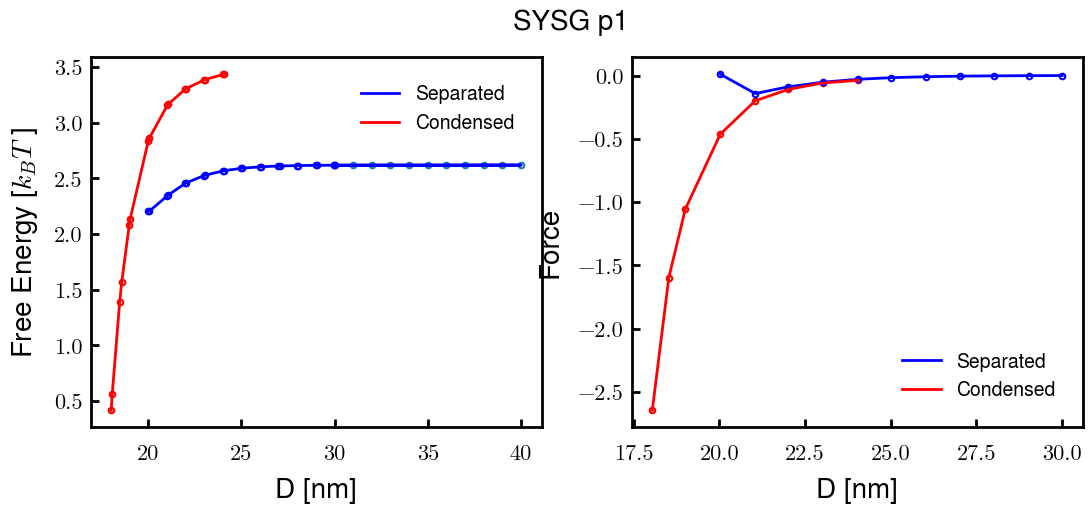

In [80]:
freeE = pd.read_csv(GIT+'p1_4030.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
d4030, y4030 = freeE.nx*17/150/2, freeE.freeE
freeE = pd.read_csv(GIT+'p1_c2520.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2520 = freeE.nx, freeE.freeE
dc2520, xc2520, fc2520 = CalcF(nx, yc2520)
freeE = pd.read_csv(GIT+'p1_s3020.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys3020 = freeE.nx, freeE.freeE
ds3020, xs3020, fs3020 = CalcF(nx, ys3020)
freeE = pd.read_csv(GIT+'p1_c1915.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc1915 = freeE.nx, freeE.freeE
dc1915, xc1915, fc1915 = CalcF(nx, yc1915)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)

if 1: 
    axs[0].plot(d4030, y4030, 'o', ms=4, markerfacecolor='none',  c='C0',  label='_4030')
    axs[0].plot(dc2520, yc2520, 'o', ms=4, markerfacecolor='none',  c='red',  label='_c2520')
    axs[0].plot(dc1915, yc1915, 'o', ms=4, markerfacecolor='none', c='red',  label='_c1915')
    axs[0].plot(ds3020, ys3020, 'o', ms=4, markerfacecolor='none',  c='blue',  label='_s3020')
axs[0].plot([*d4030, *ds3020[::-1]], [*y4030, *ys3020[::-1]], c='blue', label='Separated')
axs[0].plot([*dc2520[::-1], *dc1915[::-1]], [*yc2520[::-1], *yc1915[::-1]], c='red', label='Condensed')

if 1:
    axs[1].plot(xc2520, fc2520, 'o', ms=4, markerfacecolor='none', c='red',  label='_c2520')
    axs[1].plot(xc1915, fc1915, 'o', ms=4, markerfacecolor='none', c='red',  label='_c1915')
    axs[1].plot(xs3020, fs3020, 'o', ms=4, markerfacecolor='none', c='blue',  label='_s3020')
axs[1].plot([*xs3020[::-1]], [*fs3020[::-1]], c='blue', label='Separated')
axs[1].plot([*xc2520[::-1], *xc1915[::-1]], [*fc2520[::-1], *fc1915[::-1]], c='red', label='Condensed')

plt.suptitle('SYSG p1', fontsize=20)
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')

tjy.ticks(axs)
plt.show()

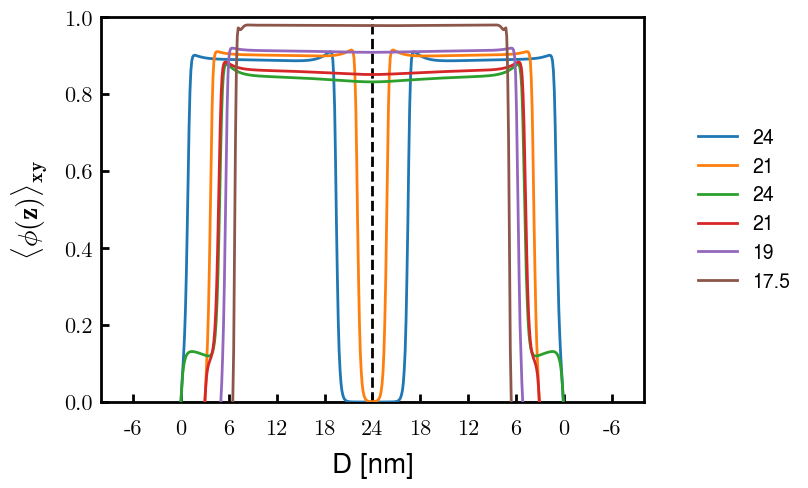

In [48]:
# SYSG 
labs = [24, 21]
read_list = [GIT+'ph_s3020d{:05.0f}.dat'.format(int(i*1000)) for i in labs]
labs2 = [24, 21]
read_list += [GIT+'ph_c2520d{:05.0f}.dat'.format(i*1000) for i in labs2]
labs += labs2
labs2 = [19, 17.5]
read_list += [GIT+'ph_c1915d{:05.0f}.dat'.format(i*1000) for i in labs2]
labs += labs2

max_d = max(labs) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
block_Ni = [[5]]*len(read_list)
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)

plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 6
xrange = np.arange(-step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-step, max_d+0.1, step), np.arange(max_d-step, -step-0.1, -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.xlabel('D [nm]')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

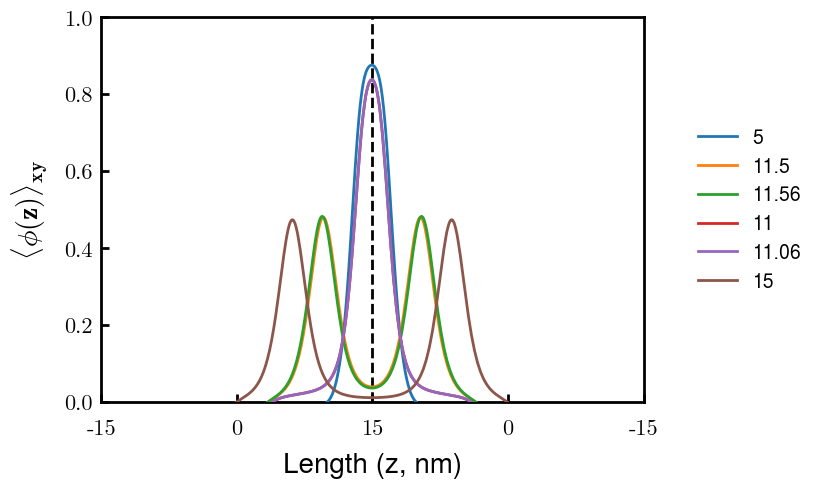

In [103]:
# NFH
labs = [5, 11.5, 11.56, 11, 11.06, 15]
read_list = [GIT+'ph_H06cd{:05d}.dat'.format(int(i*1000)) for i in labs]
# labs2 = [15, 20, 25, 30, 35]
# read_list += [GIT+'ph_H50sd{:05d}.dat'.format(int(i*1000)) for i in labs2]
# labs += labs2

max_d = max(labs) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 15
plt.xlim(-step, step)
xrange = np.arange(-1*step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-1*step, max_d+0.1, step), np.arange(max_d-step, -1*(step+0.1), -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

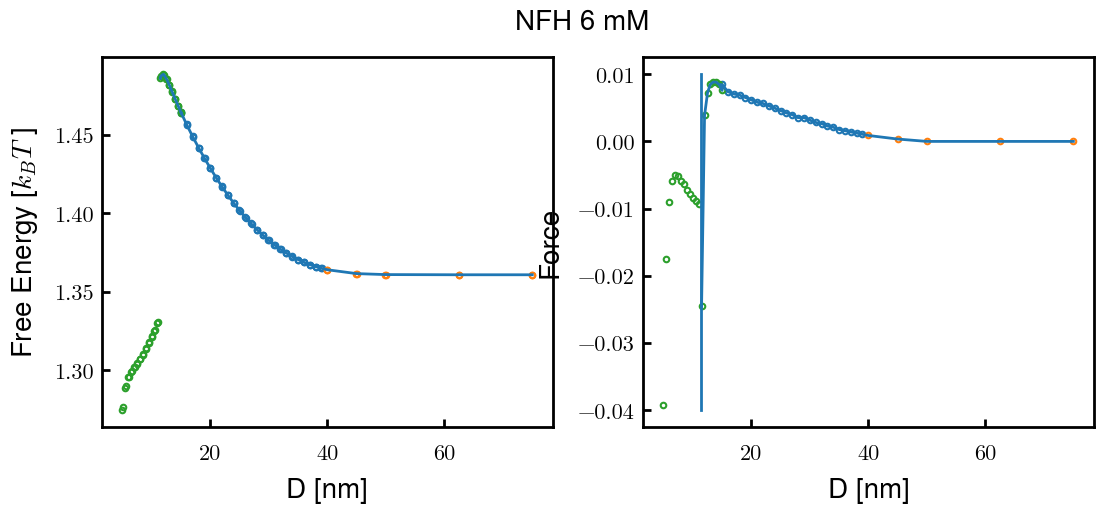

In [122]:
freeE = pd.read_csv(GIT+'NFH_06a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06a = freeE.nx, freeE.freeE
d06a, x06a, f06a = CalcF(nx, y06a)
freeE = pd.read_csv(GIT+'NFH_06b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06b = freeE.nx, freeE.freeE
d06b, x06b, f06b = CalcF(nx, y06b)
freeE = pd.read_csv(GIT+'NFH_06c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06c = freeE.nx, freeE.freeE
d06c, x06c, f06c = CalcF(nx, y06c)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
if 1: 
    axs[0].plot(d06a, y06a, 'o', ms=4, markerfacecolor='none',  c='C0', label='_H06a')
    axs[0].plot(d06b, y06b, 'o', ms=4, markerfacecolor='none',  c='C1', label='_H06b')
    axs[0].plot(d06c, y06c, 'o', ms=4, markerfacecolor='none',  c='C2', label='_H06c')
axs[0].plot([*d06c[-16:], *d06a, *d06b], [*y06c[-16:], *y06a, *y06b], c='C0')

if 1: 
    axs[1].plot(x06a, f06a, 'o', ms=4, markerfacecolor='none',  c='C0', label='_H06a')
    axs[1].plot(x06b, f06b, 'o', ms=4, markerfacecolor='none',  c='C1', label='_H06b')
    axs[1].plot(x06c, f06c, 'o', ms=4, markerfacecolor='none',  c='C2', label='_H06c')
axs[1].plot([*x06c[-8:], *x06a, *x06b], [*f06c[-8:], *f06a, *f06b], c='C0')

axs[1].plot([11.5, 11.5], [-0.04, 0.01])
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 6 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

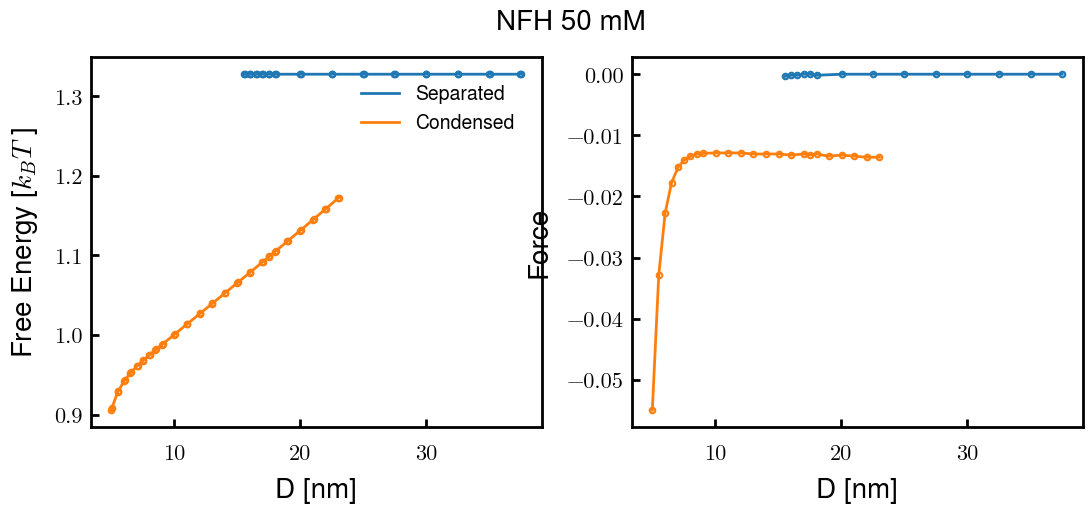

In [87]:
freeE = pd.read_csv(GIT+'NFH_50s.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys = freeE.nx[12:], freeE.freeE[12:]
ds, x50s, y50s = CalcF(nx, ys)

freeE = pd.read_csv(GIT+'NFH_50c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc = freeE.nx, freeE.freeE
dc, x50c, y50c = CalcF(nx, yc)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
if 1: 
    axs[0].plot(ds, ys, 'o', ms=4, markerfacecolor='none',  c='C0', label='_NFHs')
    axs[0].plot(dc, yc, 'o', ms = 4, markerfacecolor='none', c='C1', label='_NFHc')
axs[0].plot(ds, ys, c='C0', label='Separated')
axs[0].plot(dc, yc, c='C1', label='Condensed')
axs[0].legend()
# axs[0].plot(d, y, c='C0', label='_Raw')
if 1: 
    axs[1].plot(x50s, y50s, 'o', ms=4, markerfacecolor='none',  c='C0', label='_NFHs')
    axs[1].plot(x50c, y50c, 'o', ms=4, markerfacecolor='none',  c='C1', label='_NFHc')
axs[1].plot(x50s, y50s, c='C0', label='Separated')
axs[1].plot(x50c, y50c, c='C1', label='Condensed')
# axs[1].plot(x04f, y04f, c='C0', label='_Raw')

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
# axs[1].set_ylim([None, 0.01])
plt.suptitle('NFH 50 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

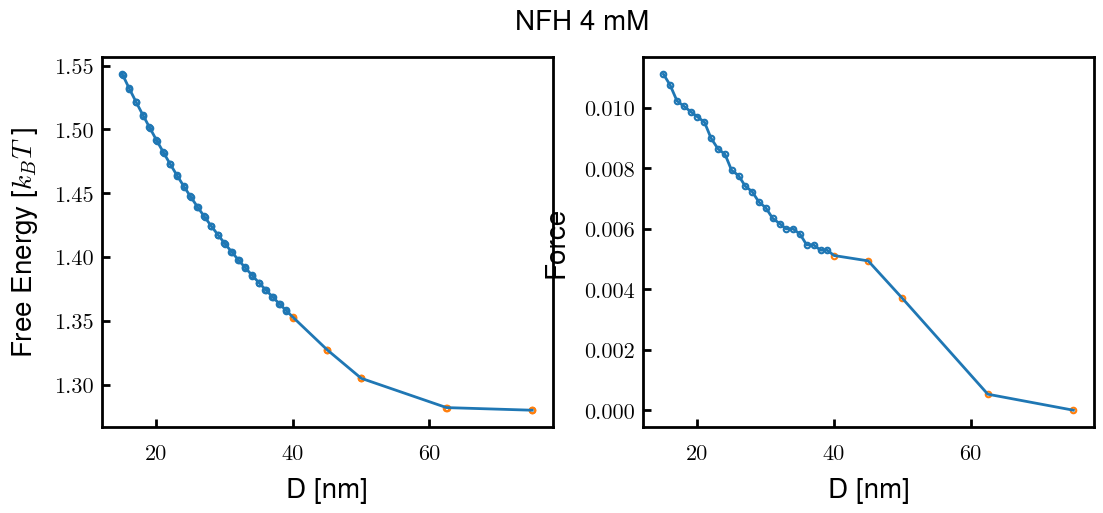

In [91]:
freeE = pd.read_csv(GIT+'NFH_04.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04 = freeE.nx, freeE.freeE
d04, x04, f04 = CalcF(nx, y04)
freeE = pd.read_csv(GIT+'NFH_04b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04b = freeE.nx, freeE.freeE
d04b, x04b, f04b = CalcF(nx, y04b)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
if 1: 
    axs[0].plot(d04, y04, 'o', ms=4, markerfacecolor='none',  c='C0', label='_H04a')
    axs[0].plot(d04b, y04b, 'o', ms=4, markerfacecolor='none',  c='C1', label='_H04b')
axs[0].plot([*d04, *d04b], [*y04, *y04b], c='C0')

if 1:
    axs[1].plot(x04, f04, 'o', ms=4, markerfacecolor='none',  c='C0', label='_H04a')
    axs[1].plot(x04b, f04b, 'o', ms=4, markerfacecolor='none',  c='C1', label='_H04b')
axs[1].plot([*x04, *x04b], [*f04, *f04b], c='C0')

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 4 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

619
Fail: 441 N versus 440 New


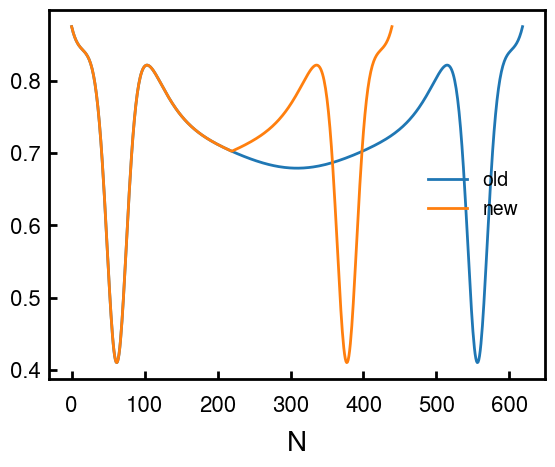

In [23]:
## Adjust D (half-space)
filename = 'W_a020d35060.dat' #Nx = 100, dx = 17.0/150
dx = 17/150
new_Lx = 50
N = round(new_Lx / dx)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)
old_N = len(df.index)
print(old_N)
# display(df)

if N > old_N: 
    rem = ['['] + [1.00]*5 + [']'] + [-1.00] + [1.00] + [0.00]
    rem = pd.DataFrame([rem for i in range(N-old_N)], columns=names)
    new = pd.concat([df.iloc[:round(old_N/2)], rem, df.iloc[-round(old_N/2):]], ignore_index=True)
else: 
    shave = df.iloc[0:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]], ignore_index=True)
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    # new.to_csv('./imgs/W_sym{}.dat'.format(new_Lx), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))
    
if True: 
    plt.plot(df.w1, label='old')
    plt.plot(new.w1, label='new')
    plt.legend()
    plt.xlabel('N')

Success: 706 == 706.


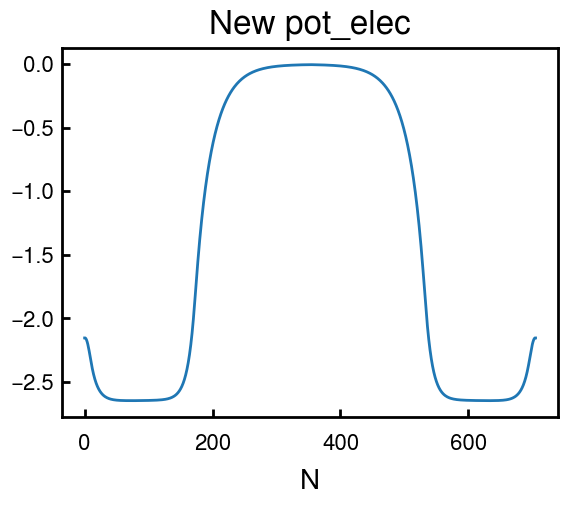

In [87]:
## SINGLE --> DOUBLE WA
filename = 'W_a040c010_x200s002.dat' #Nx = 100, dx = 17.0/150
dx = 17/150
new_Lx = 80
N = round(new_Lx / dx)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)
# display(df)

if N > 2*len(df.index): 
    rem = ['['] + [1.00]*5 + [']'] + [-1.00]*2 + [0.00]
    rem = pd.DataFrame([rem for i in range(N-2*len(df.index))], columns=names)
    new = pd.concat([df, rem, df.iloc[::-1]], ignore_index=True)
else: 
    shave = df.iloc[0:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]], ignore_index=True)
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    new.to_csv('./imgs/W_sym{}.dat'.format(new_Lx), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))
    
if True:
    plt.plot(new.pot_elec)
    plt.title('New pot_elec')
    plt.xlabel('N')

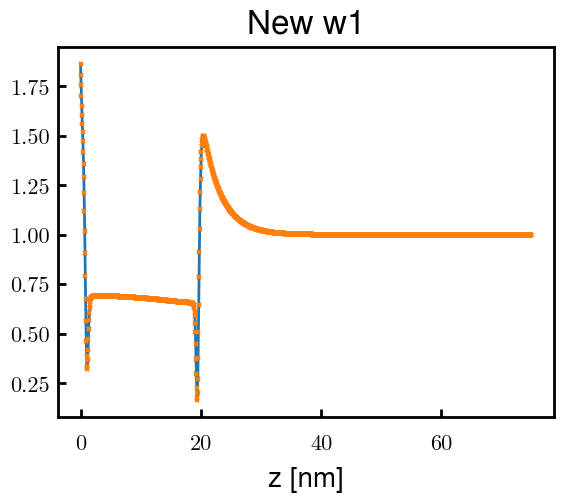

In [140]:
## SINGLE dx1 --> dx2
from scipy.interpolate import CubicSpline
filename = 'W_a040c010_x200s002.dat' #Nx = 75, dx = 17.0/150
dx1 = 17.0/150 # Old
dx2 = 0.05 # New
Lx = 75
Nx1, Nx2 = round(Lx/dx1), round(Lx/dx2)

x1 = np.arange(0, Lx, dx1)
x2 = np.arange(0, Lx, dx2)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)

if True: 
    test_frame = df.w1
    cs = CubicSpline(x1, test_frame)
    plt.plot(x1, test_frame)
    plt.plot(x2, cs(x2), 'x', markerfacecolor='w', ms=3)

    plt.title('New w1')
    plt.xlabel('z [nm]')
    tjy.ticks()
    plt.show()

A = []
for i in [1, 2, 3, 4, 5, 7, 8, 9]:
    cs = CubicSpline(x1, df.iloc[:, i])
    A = [*A, cs(x2)]
fill = np.array(['[']*(Nx2))
A = [fill, A[0], A[1], A[2], A[3], A[4], fill, A[5], A[6], A[7]]
new = pd.DataFrame(A).transpose()
new.to_csv('./imgs/W_dx{}.dat'.format(dx2*100), sep='\t', float_format='%10.5e', header=False, index=False)